<a href="https://colab.research.google.com/github/adem99307/POM/blob/main/POM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-multilearn
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 2.1 MB/s eta 0:00:00


In [2]:
# Next we load the data from csv files into a pandas dataframe and check its attributes.
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/train.csv'

data_raw = pd.read_csv(dataset_path)
data_raw = data_raw.sample(n=5000)
missing_mask = np.random.choice([False, True], size=data_raw.shape[0]*data_raw.shape[1], p=[0.8, 0.2])
#data_raw.values[missing_mask] = np.nan


print("Number of rows in data =",data_raw.shape[0])

print("Number of columns in data =",data_raw.shape[1])
print("\n")
print("**Sample data:**")
data_raw.head()



Mounted at /content/drive
Number of rows in data = 5000
Number of columns in data = 8


**Sample data:**


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
145070,16df7e6559fa7736,", as it was mentioned in more than one publica...",0,0,0,0,0,0
107906,40c74ffcf88e72c4,"""\n\n hmm \n\nok well i see you using alot of ...",0,0,0,0,0,0
104556,2f62b01d668be91a,you are a mother fucker,1,0,1,0,1,0
110760,50843b8bd1113cd4,"@KWWWWWWW if u don't believed I called them, i...",1,0,1,0,1,0
73254,c3fb2e1c9f92cbc9,"""\nFurthermore, I'm going to have to give you ...",0,0,0,0,0,0


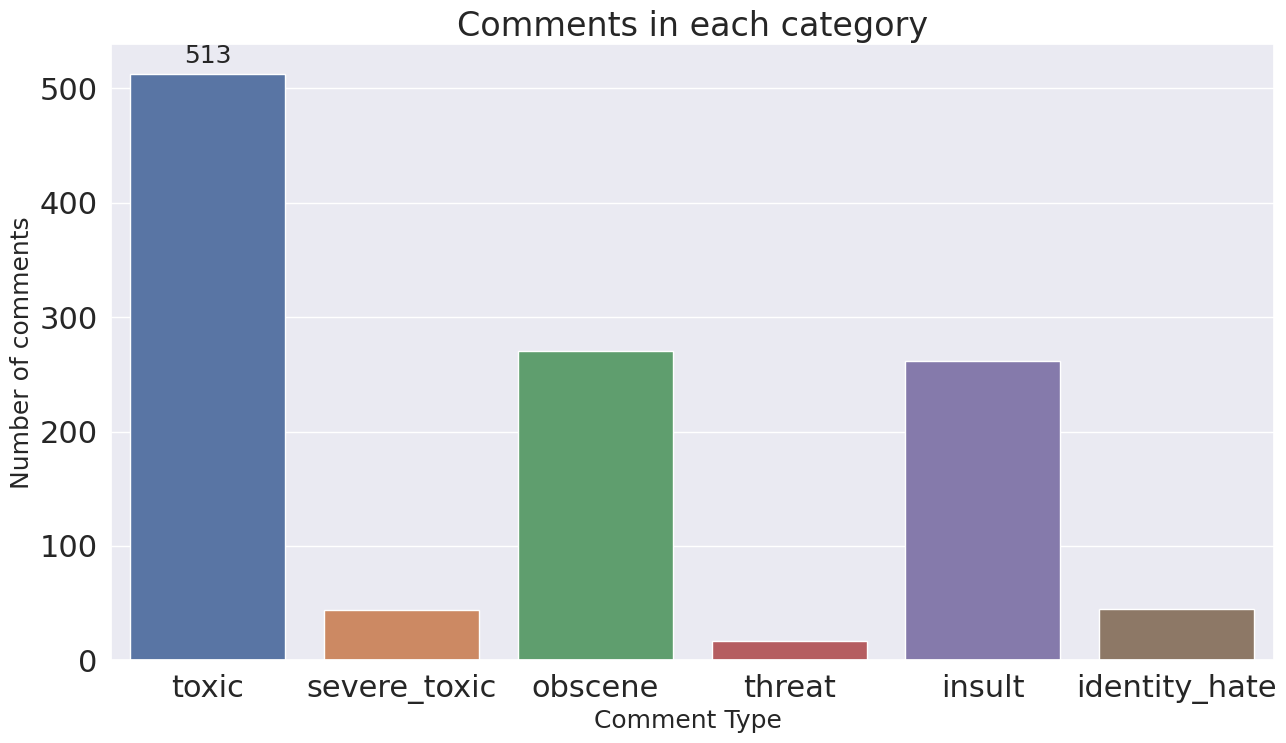

In [3]:
categories = list(data_raw.columns.values)[2:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=categories, y=data_raw.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    plt.show()

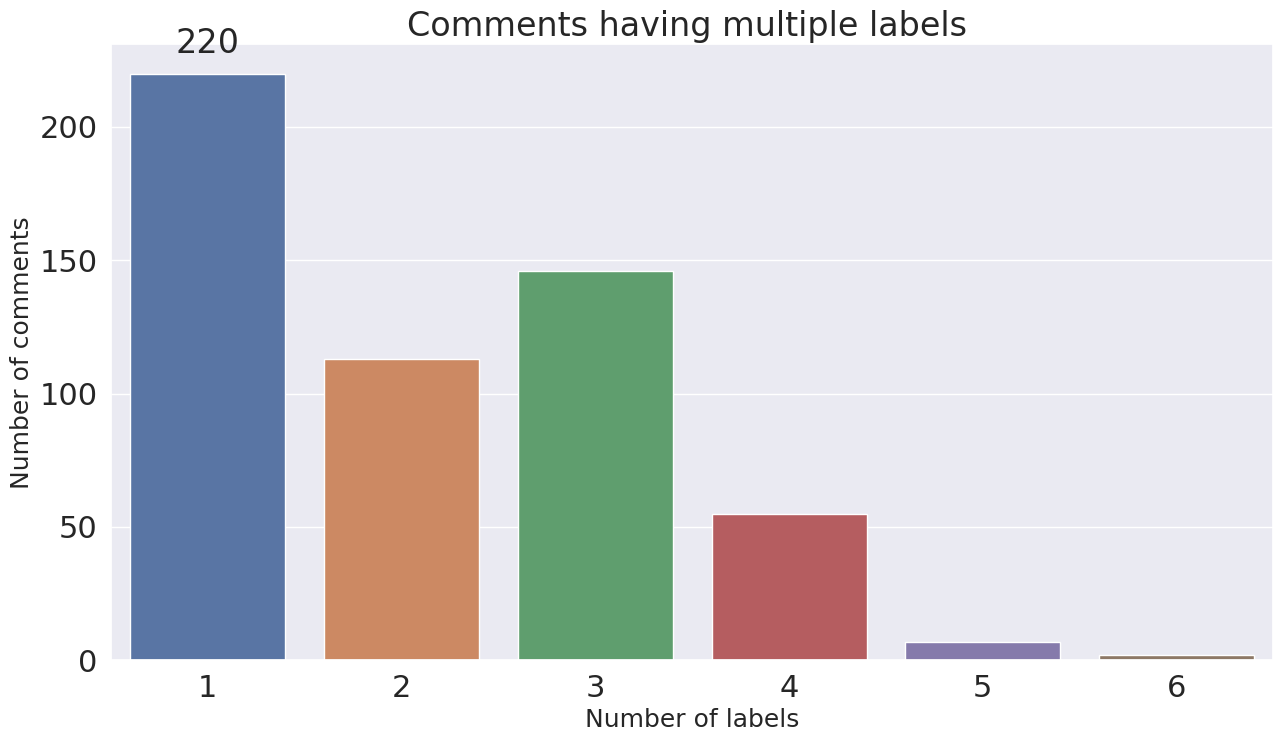

In [4]:
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=multiLabel_counts.index,y=multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.show()

**Data prepocessing**

In [5]:
#Prepocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
    data['comment_text'] = data['comment_text'].apply(removeStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['comment_text'] = data['comment_text'].apply(stemming)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

#x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)

y_train = train.drop(labels = ['id','comment_text'], axis=1)
y_test = test.drop(labels = ['id','comment_text'], axis=1)



In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
cv = CountVectorizer()
X_train = cv.fit_transform(train['comment_text'])
X_test = cv.transform(test['comment_text'])


# TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(train['comment_text'])
X_test_tfidf = tfidf.transform(test['comment_text'])

**Part-5: Multi-Label Classification Techniques:**

**1. OneVsRest**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])


# Training logistic regression model on train data
LogReg_pipeline.fit(X_train_tfidf,y_train)    
# calculating test accuracy
ovr_y_pred = LogReg_pipeline.predict(X_test_tfidf)
print('Test accuracy is {}'.format(accuracy_score(y_test, ovr_y_pred)))
print("\n")



Test accuracy is 0.9




**2. Binary Relevance**

In [36]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())# train
classifier.fit(X_train_tfidf, y_train)# predict
br_y_pred = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,br_y_pred))


Accuracy =  0.8026666666666666


**3. Classifier Chains**




In [37]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())# Training logistic regression model on train data
classifier.fit(X_train_tfidf, y_train)# predict
cc_y_pred = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,cc_y_pred))
print("\n")

Accuracy =  0.9033333333333333




**4. Label Powerset**

In [38]:
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())# train
classifier.fit(X_train_tfidf, y_train)# predict
lp_y_pred = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,lp_y_pred))
print("\n")

Accuracy =  0.8986666666666666






```
# Ce texte est au format code
```

**5. BSVM Binary Support Vector Machine**

In [39]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

# Create a Binary Support Vector Machine (BSVM) classifier
svm = SVC(kernel='linear', probability=True)

# Create a multi-output classifier with BSVM
multi_svm = MultiOutputClassifier(svm, n_jobs=-1)

# Train the classifier on the training data
multi_svm.fit(X_train_tfidf, y_train)

# Predict the labels for the test data
bsvm_y_pred = multi_svm.predict(X_test_tfidf)
print("Accuracy = ",accuracy_score(y_test,bsvm_y_pred))


Accuracy =  0.9133333333333333


**Comparaison:**

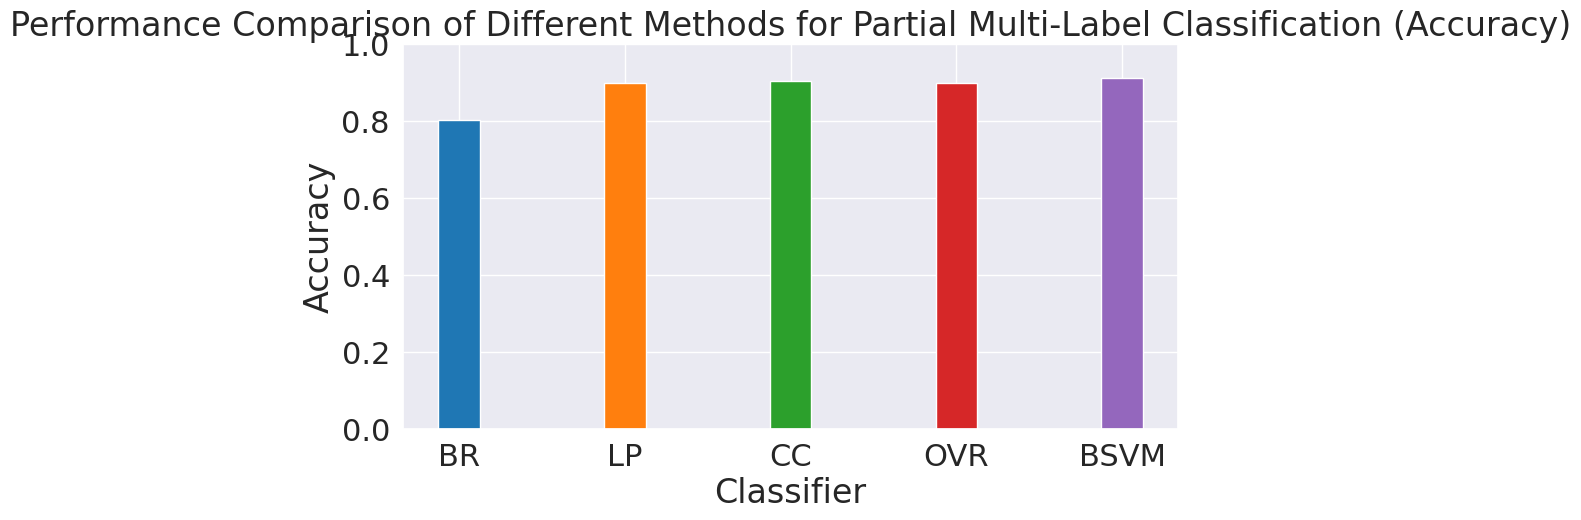

In [43]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

br_accuracy = accuracy_score(y_test, br_y_pred)
br_hamming_loss = hamming_loss(y_test, br_y_pred)
br_f1_score = f1_score(y_test, br_y_pred, average='micro')

lp_accuracy = accuracy_score(y_test, lp_y_pred)
lp_hamming_loss = hamming_loss(y_test, lp_y_pred)
lp_f1_score = f1_score(y_test, lp_y_pred, average='micro')

cc_accuracy = accuracy_score(y_test, cc_y_pred)
cc_hamming_loss = hamming_loss(y_test, cc_y_pred)
cc_f1_score = f1_score(y_test, cc_y_pred, average='micro')

ovr_accuracy = accuracy_score(y_test, ovr_y_pred)
ovr_hamming_loss = hamming_loss(y_test, ovr_y_pred)
ovr_f1_score = f1_score(y_test, ovr_y_pred, average='micro')

bsvm_accuracy = accuracy_score(y_test, bsvm_y_pred)
bsvm_hamming_loss = hamming_loss(y_test, bsvm_y_pred)
bsvm_f1_score = f1_score(y_test, bsvm_y_pred, average='micro')

# Create a list of the evaluation metrics for each classifier
accuracies = [br_accuracy, lp_accuracy, cc_accuracy, ovr_accuracy, bsvm_accuracy]
hamming_losses = [br_hamming_loss, lp_hamming_loss, cc_hamming_loss, ovr_hamming_loss, bsvm_hamming_loss]
f1_scores = [br_f1_score, lp_f1_score, cc_f1_score, ovr_f1_score, bsvm_f1_score]

# Set the labels for the classifiers
labels = ['BR', 'LP', 'CC', 'OVR', 'BSVM']

# Set the colors for the bars
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Set the width of the bars
width = 0.25

# Set the positions of the bars on the x-axis
x_positions = np.arange(len(labels))

# Plot the bar chart for accuracy

plt.figure(figsize=(10, 5))
plt.bar(x_positions, accuracies, width, color=colors)
plt.xticks(x_positions, labels)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Performance Comparison of Different Methods for Partial Multi-Label Classification (Accuracy)')
plt.ylim([0, 1])
plt.show()
print("\n")



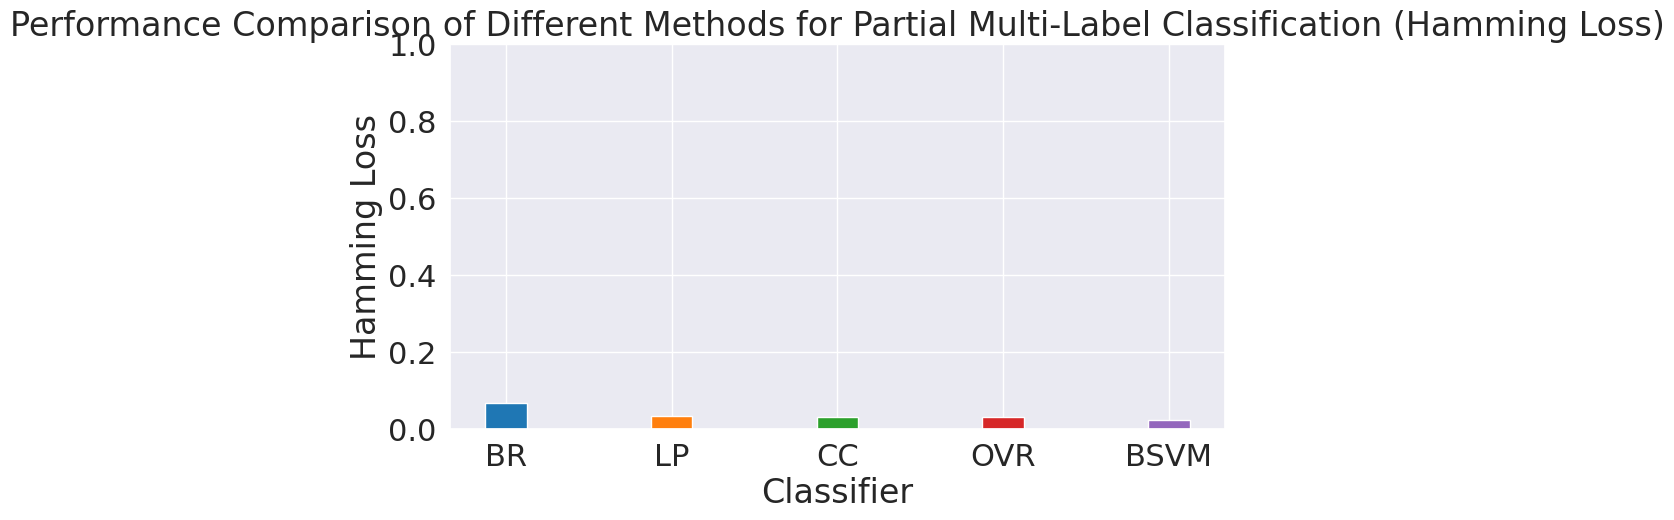

In [44]:
# Plot the bar chart for hamming loss
plt.figure(figsize=(10, 5))
plt.bar(x_positions, hamming_losses, width, color=colors)
plt.xticks(x_positions, labels)
plt.xlabel('Classifier')
plt.ylabel('Hamming Loss')
plt.title('Performance Comparison of Different Methods for Partial Multi-Label Classification (Hamming Loss)')
plt.ylim([0, 1])
plt.show()
print("\n")


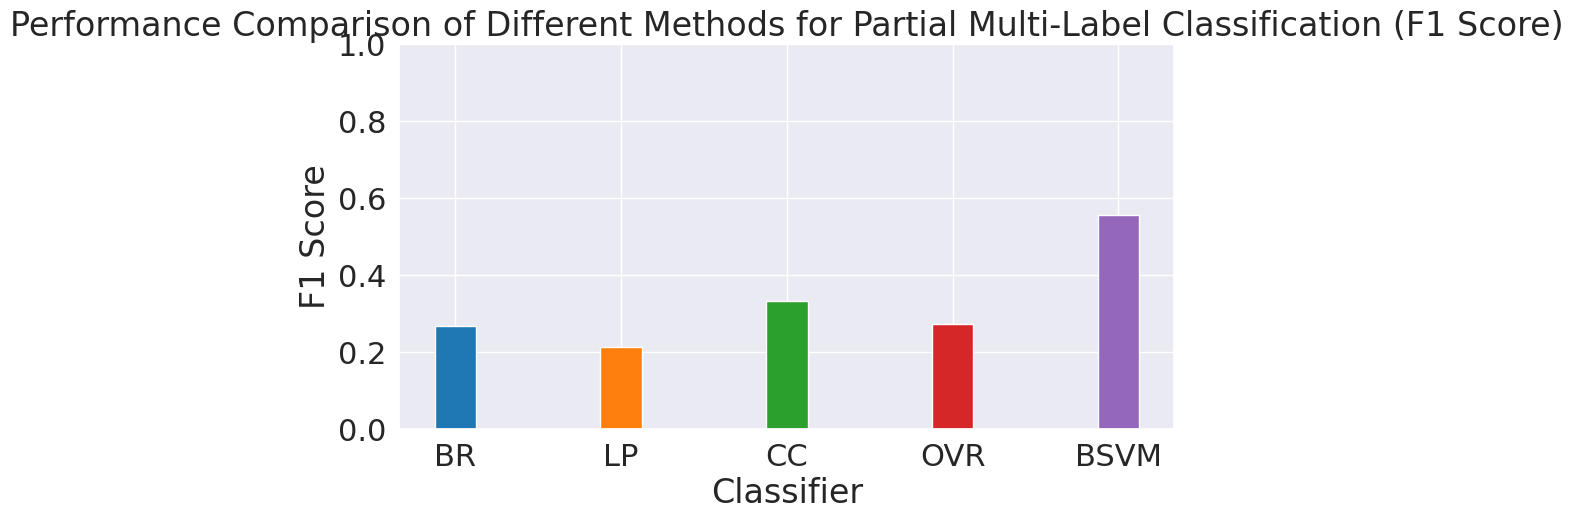

In [45]:
# Plot the bar chart for F1 score
plt.figure(figsize=(10, 5))
plt.bar(x_positions, f1_scores, width, color=colors)
plt.xticks(x_positions, labels)
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('Performance Comparison of Different Methods for Partial Multi-Label Classification (F1 Score)')
plt.ylim([0, 1])
plt.show()

**We see correctly that the BSVM method is the best in term of performance compared with others.**